# **Overview**
With increased demand for solar energy, comes an increased need to ensure that solar energy plants are constructed in optimal locations, such as locations with a large amount of solar irradiance.

Typically solar collectors are not mounted horizontally, but at an angle. It is necessary to calculate total solar radiation values on a tilted surface given values on a horizontal surface. It is not possible to just use trigonometric relationships. This is because diffuse radiation is anisotropic in the sky, and tilted solar collector will collect diffuse radiation differently depending on its orientation.

Additionally for concentrated solar thermal systems, we need to konw global and direct normal solar irradiance.

Solar Irradiance is measured in several different ways:

Global Horizontal Irradiance (GHI) is total amount of shortwave radiation received from above by a surface horizontal to the ground. This value is of particular interest to photovoltaic installations and includes both Direct Normal Irradiance (DNI) and Diffuse Horizontal Irradiance (DHI).

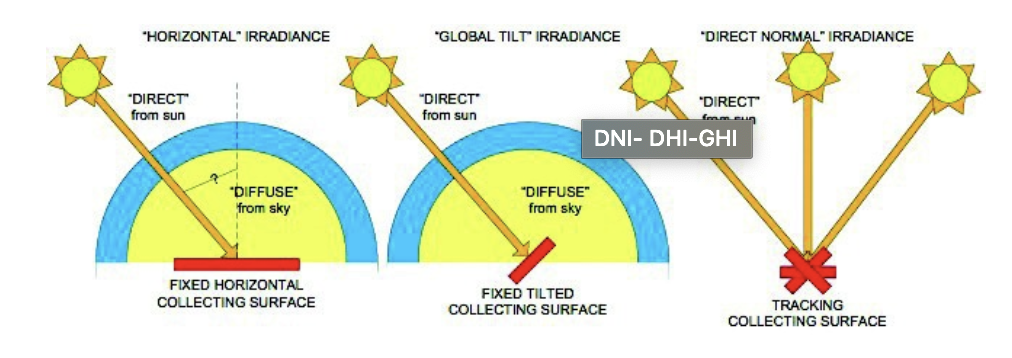

In [1]:
import numpy as np
import random

import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
#RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error

from numpy import split
from numpy import array

#LSTM MODEL
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# **DATA**
Data was pulled from [the National Solar Radiation Database](https://nsrdb.nrel.gov/data-viewer)

National Solar Radiation Database data is a collection of hourly TMY datasets containing meteorological data and the three most common measurements of solar radiation: global horizontal, direct normal and diffuse horizontal irradiance. The data is synthetic in that GHI and DHI are modeled from the REST2 and FARMS models.

In [2]:
from google.colab import files

# Upload multiple files
uploaded = files.upload()

# Checking the uploaded files
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Saving 623444_35.37_9.90_2017.csv to 623444_35.37_9.90_2017.csv
Saving 623444_35.37_9.90_2018.csv to 623444_35.37_9.90_2018.csv
Saving 623444_35.37_9.90_2019.csv to 623444_35.37_9.90_2019.csv
Uploaded file: 623444_35.37_9.90_2017.csv
Uploaded file: 623444_35.37_9.90_2018.csv
Uploaded file: 623444_35.37_9.90_2019.csv


In [3]:
import pandas as pd

# Load the files into DataFrames
df1 = pd.read_csv("623444_35.37_9.90_2017.csv")  # Replace with actual file names
df2 = pd.read_csv("623444_35.37_9.90_2018.csv")
df3 = pd.read_csv("623444_35.37_9.90_2019.csv")

df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)
df

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,Fill Flag,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
0,2017,1,1,0,0,9.1,0,0,0,0,...,0,0,0.286,65.62,166.62,0.25,1001,0.7,296,1.8
1,2017,1,1,0,15,9.1,0,0,0,0,...,0,0,0.286,65.62,167.51,0.25,1001,0.7,296,1.8
2,2017,1,1,0,30,9.1,0,0,0,0,...,0,0,0.286,65.62,167.58,0.25,1001,0.7,296,1.8
3,2017,1,1,0,45,9.1,0,0,0,0,...,0,0,0.286,65.62,166.81,0.25,1001,0.7,296,1.8
4,2017,1,1,1,0,3.5,0,0,0,0,...,0,0,0.296,84.16,165.34,0.24,1008,0.7,309,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105115,2019,12,31,22,45,4.1,0,0,0,0,...,0,0,0.319,89.28,155.35,0.25,1010,0.8,347,2.1
105116,2019,12,31,23,0,4.0,0,0,0,0,...,0,0,0.318,89.91,158.10,0.25,1010,0.8,345,2.1
105117,2019,12,31,23,15,3.9,0,0,0,0,...,0,0,0.317,90.54,160.70,0.25,1010,0.8,344,2.2
105118,2019,12,31,23,30,3.8,0,0,0,0,...,0,0,0.316,91.18,163.08,0.25,1010,0.8,343,2.2


In [4]:
df.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Clearsky DHI',
       'Clearsky DNI', 'Clearsky GHI', 'Cloud Type', 'Dew Point', 'DHI', 'DNI',
       'Fill Flag', 'GHI', 'Ozone', 'Relative Humidity', 'Solar Zenith Angle',
       'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction',
       'Wind Speed'],
      dtype='object')

---

### Explanation of Column Selection

In this analysis, I dropped the following columns from the dataset:

- **DHI (Diffuse Horizontal Irradiance)**
- **DNI (Direct Normal Irradiance)**
- **Clearsky DHI**
- **Clearsky DNI**
- **Clearsky GHI**
- **Fill Flag**
- **Cloud Type**

#### Reason for Dropping These Columns:
1. **Target Prediction:**  
   - The goal is to predict the minimum value of **Global Horizontal Irradiance (GHI)**.
   - Including columns like **DHI** and **DNI** would lead to data leakage since these variables are directly used in the formula for calculating GHI:

   **Global Horizontal (GHI) = Direct Normal (DNI) X cos(θ) + Diffuse Horizontal (DHI)**

2. **Redundancy:**  
   - The columns **Clearsky DHI**, **Clearsky DNI**, and **Clearsky GHI** represent idealized or modeled data and may not provide relevant insights for the prediction task.

3. **Irrelevance:**  
   - Columns like **Fill Flag** and **Cloud Type** are either categorical or unrelated to the numerical prediction of GHI and can be omitted to simplify the model.

This step ensures that the model uses meaningful features without introducing bias or relying on derived variables.

---

In [5]:
df=df.drop(["DHI","DNI","Clearsky DHI" ,"Clearsky DNI","Clearsky GHI","Fill Flag","Cloud Type"], axis = 1)

-  made  the  datetime  column  as an  index.

In [6]:
cols = ["Year","Month","Day","Hour","Minute"]
df["date_time"] = df[cols].apply(lambda row: "-".join(row.values.astype(str)), axis=1)

In [7]:
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d-%H-%M')

In [8]:
df=df.drop(["Year","Month","Day","Hour","Minute"], axis = 1)

In [9]:
df=df.set_index('date_time') #index column

In [10]:
df.head(1000)

,Temperature,Dew Point,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
date_time,,,,,,,,,,,
2017-01-01 00:00:00,9.1,3.0,0,0.286,65.62,166.62,0.25,1001,0.7,296,1.8
2017-01-01 00:15:00,9.1,3.0,0,0.286,65.62,167.51,0.25,1001,0.7,296,1.8
2017-01-01 00:30:00,9.1,3.0,0,0.286,65.62,167.58,0.25,1001,0.7,296,1.8
2017-01-01 00:45:00,9.1,3.0,0,0.286,65.62,166.81,0.25,1001,0.7,296,1.8
2017-01-01 01:00:00,3.5,1.1,0,0.296,84.16,165.34,0.24,1008,0.7,309,1.2
...,...,...,...,...,...,...,...,...,...,...,...
2017-01-11 08:45:00,8.7,3.8,50,0.363,71.47,77.76,0.24,990,1.4,308,2.4
2017-01-11 09:00:00,9.3,3.8,65,0.363,68.64,75.41,0.24,990,1.4,312,2.6
2017-01-11 09:15:00,10.0,3.8,80,0.362,65.50,73.15,0.24,990,1.4,316,2.5


In [11]:
df.columns

Index(['Temperature', 'Dew Point', 'GHI', 'Ozone', 'Relative Humidity',
       'Solar Zenith Angle', 'Surface Albedo', 'Pressure',
       'Precipitable Water', 'Wind Direction', 'Wind Speed'],
      dtype='object')

In [12]:
df.describe()

,Temperature,Dew Point,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
count,105120.000000,105120.000000,105120.000000,105120.000000,105120.000000,105120.000000,105120.000000,105120.000000,105120.000000,105120.000000,105120.000000
mean,19.254571,9.492129,209.114155,0.310898,59.442786,89.684710,0.260438,995.750723,2.064675,210.538023,2.870972
std,9.137643,5.334460,299.947485,0.028577,23.565634,38.427736,0.017806,5.410660,0.868161,107.884605,1.713714
min,0.500000,-5.500000,0.000000,0.239000,7.980000,12.030000,0.220000,970.000000,0.400000,0.000000,0.000000
25%,11.800000,5.400000,0.000000,0.290000,40.170000,58.640000,0.240000,993.000000,1.300000,124.000000,1.500000
50%,18.500000,9.400000,0.000000,0.306000,60.320000,89.290000,0.260000,996.000000,2.000000,223.000000,2.600000
75%,25.600000,13.500000,395.000000,0.328000,79.010000,120.980000,0.280000,999.000000,2.700000,311.000000,3.900000
max,47.300000,22.900000,1052.000000,0.466000,100.000000,168.040000,0.300000,1015.000000,4.900000,360.000000,12.500000


I put the value I want to predict in the last column

In [13]:
df1 = df.pop('GHI') #  Delete  GHI  column  and  store  it  in  df1
df['GHI']=df1
df.columns

Index(['Temperature', 'Dew Point', 'Ozone', 'Relative Humidity',
       'Solar Zenith Angle', 'Surface Albedo', 'Pressure',
       'Precipitable Water', 'Wind Direction', 'Wind Speed', 'GHI'],
      dtype='object')

In [14]:
def split_dataset(df):
  train=df[:104448]

  test=df[104448:]
  train = array(split(train, len(train)/4))# 96  because  I  did  daily  division
  test = array(split(test, len(test)/4))
  return train, test

 separate  the  inputs  as  numpy  arrays.

In [15]:
train, test = split_dataset(df.values)# split  the  dataset

---

### Dataset Preparation and Structure

The dataset consists of **96 measurements per day**, recorded every 15 minutes. To streamline testing and training:

1. **Training Set:**
   - A learning dataset was created using **1,088 days** of data.
   - With **11 features per row**, the training data is reshaped to the structure **(26112, 4, 11)**, where:
     - `26112`: Total patterns (1088 days × 24 time windows/day).
     - `4`: Time steps in each input sequence.
     - `11`: Features per time step.

2. **Test Set:**
   - A smaller test set was prepared, corresponding to **1 week** of data.
   - The test set structure is **(168, 4, 11)**:
     - `168`: Total patterns (7 days × 24 time windows/day).
     - `4`: Time steps in each input sequence.
     - `11`: Features per time step.

This approach ensures efficient processing while keeping the test set manageable.

---

In [16]:
print('train shape == {}.'.format(train.shape))
print('test shape == {}.'.format(test.shape))

train shape == (26112, 4, 11).
test shape == (168, 4, 11).


In [17]:
def evaluate_forecasts(actual, predicted):
	scores = list()
	#   loop  through  each  actual  (test)  value  and  measure  the  rmse  value
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)#save  all
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [18]:
#  Visualize  the  score  (Rmse  values)
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

---

### Time Step Optimization and Input/Output Selection

To capture trends in solar radiation data, it’s important to optimize the input-output windows:

1. **Data Overview:**
   - The dataset has **96 points per day**, but solar radiation is significant only between **8 AM and 5 PM**.

2. **Input/Output Design:**
   - Using **1 full day (96 points)** as input to predict only the **morning radiation of the same day** may lead to unrealistic results.
   - A better approach is to focus on **partial days** (e.g., 12 hours) for input and predict relevant future time periods (e.g., 4–6 hours).

3. **Next Steps:**
   - Experiment with input-output lengths to find the best configuration for capturing daily patterns while maintaining accuracy.

---


In [19]:
#   set  input  and  output  values
def to_supervised(train, n_input, n_out=4):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [20]:
X,y=to_supervised(train, 4)
y.shape

(104441, 4)

---

### Model Optimization and Improvements

To improve the model's performance, the following steps are considered:

1. **Hyperparameter Tuning:**
   - Adjusting the **number of neurons**.
   - Adding **dropout layers** to prevent overfitting.
   - Experimenting with different **activation functions**.
   - Testing various **optimizers** (e.g., Adam, RMSprop).

2. **Further Analysis:**
   - Tracking **model duration** to evaluate processing efficiency.
   - Plotting the **loss graph** to check if gradient descent converges to the minimum.

3. **Implementation Enhancements:**
   - Building the model using **TensorFlow** to potentially speed up training and allow for easier experimentation.

These steps aim to refine the model and ensure optimal performance.

---

In [21]:
# train the model
def build_model(train, n_input):

	verbose, epochs, batch_size = 1, 20, 16
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	train_size = (len(train_x) // batch_size) * batch_size

# Trim the dataset
	train_x = train_x[:train_size]
	train_y = train_y[:train_size]

	# define parameters

   #timesteps  is  the  96  value  we  specified  (1  day)
   #feature,  number  of  features  =  13
   #output,(n_output)  value  is  the  2nd  value  of
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(MaxPooling1D(pool_size=2))
	model.add(LSTM(128, activation='relu', return_sequences=True))
	model.add(LSTM(128, activation='relu'))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(128, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(64, activation='relu')))
	model.add(TimeDistributed(Dense(1)))

	model.compile(optimizer = Adam(learning_rate=0.001), loss='mean_squared_error')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model


- **Input Parameters:**
  - `model`: The trained model is used to generate predictions based on input data.
  - `history`: A list of past observations that the model uses to forecast the next value.
  - `n_input`: Specifies how many past time steps to consider for making the forecast.
  
- **Steps:**
  1. **Flatten Historical Data:** The `history` list is reshaped into a single 2D array with all past data combined for easier access.
  2. **Select Recent Data:** The last `n_input` rows of the data are selected to serve as input for the prediction.
  3. **Reshape for the Model:** Input is reshaped to match the model's expected input shape: `[batch_size=1, n_input, features]`.
  4. **Model Prediction:** The model predicts the output for the next time step.
  5. **Extract Prediction:** Since the model predicts in batches, the batch dimension is removed to return just the forecast vector.

In [22]:
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [23]:
# run  the  model  on  train  and  compare  it  with  the  test
def evaluate_model(train, test, n_input):

	model = build_model(train, n_input)
	model.history.history.keys()
	history = [x for x in train]
	myloss = model.history.history["loss"]

	predictions = list()
	#test_loss=0
	#_,labels=to_supervised(test, n_input)
	#print(labels.shape)
	for i in range(len(test)):
		yhat_sequence = forecast(model, history, n_input)
		#test_loss+=(((labels[i]-yhat_sequence)**2).sum()/4)/len(test)

		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
    #arrangement  of  test  data  by  index  and  prediction
		history.append(test[i, :])
	# evaluate predictions hours for each day
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, model, myloss, predictions

In [24]:
n_input = 4
score, scores, model, loss, predictions = evaluate_model(train, test, n_input)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 11.0756
Epoch 2/20
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 0.7278
Epoch 3/20
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.5212
Epoch 4/20
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.4069
Epoch 5/20
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.3496
Epoch 6/20
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.3318
Epoch 7/20
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.2883
Epoch 8/20
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.2637
Epoch 9/20
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.2474
Epoch 10/20
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.2312
Epoch 11/20
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.2280
Epoch 12/20
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.2073
Epoch 13/20
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.2082
Epoch 14/20
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.1993
Epoch 15/20
65

<ipython-input-17-05b57554fa58>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = sqrt(s / (actual.shape[0] * actual.shape[1]))


In [25]:
summarize_scores('lstm:rmse ortalama', score, scores)

lstm:rmse ortalama: [0.469] 0.3, 0.4, 0.5, 0.6


# **Plot Results**

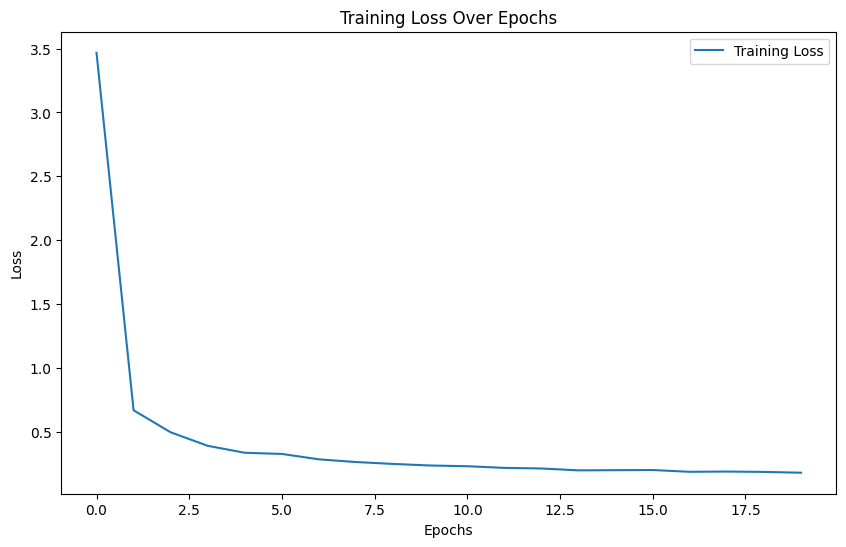

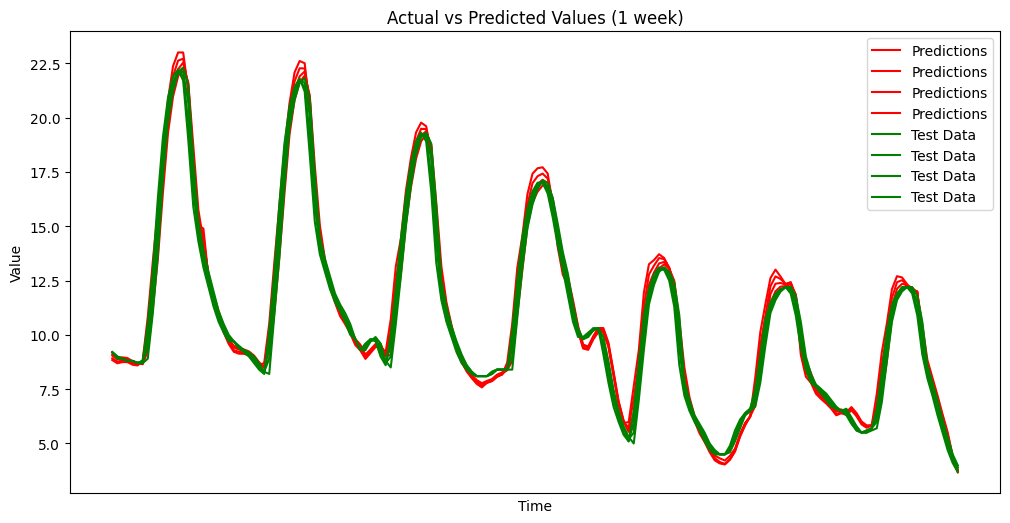

In [49]:
import matplotlib.pyplot as plt

# Plot training loss over epochs
def plot_training_loss(loss):
    plt.figure(figsize=(10, 6))
    plt.plot(loss, label="Training Loss")
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Plot actual vs predicted values
def plot_predictions(train, test, predictions):
    plt.figure(figsize=(12, 6))


    # Plot the predicted values
    plt.plot(range(len(train), len(train) + len(test)), predictions[:, :, 0], label="Predictions", color='red')

    # Plot the actual test values
    plt.plot(range(len(train), len(train) + len(test)), test[:, :, 0], label="Test Data", color='green')

    # Labels and title
    plt.title("Actual vs Predicted Values (1 week)")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.xticks([])

    plt.show()


# Plot the loss
plot_training_loss(loss)

# Plot the predictions vs actual values
plot_predictions(train, test, predictions)

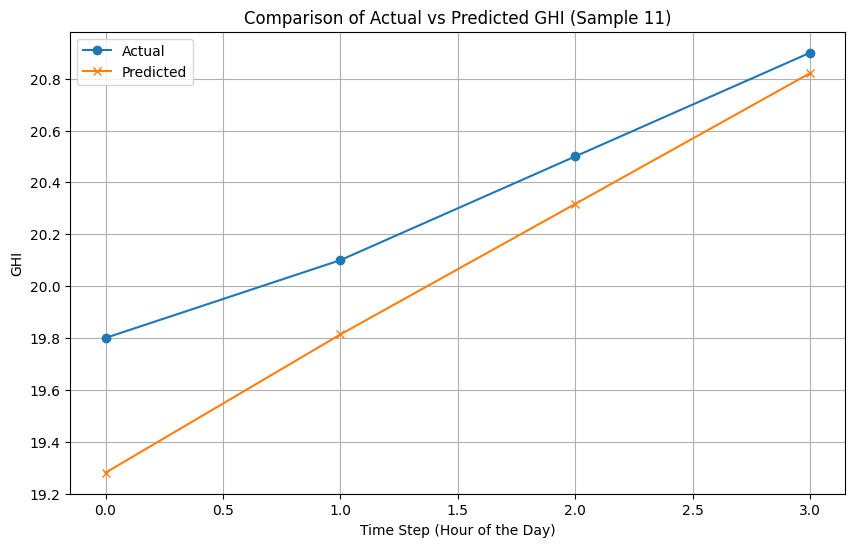

In [47]:
# Pick a random day from the test set
random_index = random.randint(0, len(test) - 1)

# Extract actual and predicted values for the selected index
actual = test[random_index, :, 0]  # Assuming the first feature is GHI
predicted = predictions[random_index]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(actual, label="Actual", marker="o")
plt.plot(predicted, label="Predicted", marker="x")
plt.title(f"Comparison of Actual vs Predicted GHI (Sample {random_index})")
plt.xlabel("Time Step (Hour of the Day)")
plt.ylabel("GHI")
plt.legend()
plt.grid()
plt.show()

# **Saving model**

In [43]:
model.save("my_model.h5")